In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 12:26:24 2024

This is the first attempt to build a regression neural network
that would be able to determine the sizes and concentrations
of nanoparticles in a solution based on the characteristic
dependence of autocorrelation function amplitude on the
scattering vector as measured with c-DDM.

First, a Pandas dataframe with limited experimental data is loaded,
then, a lot of additional data is crated artificially, based on distribution
of experimental amplitudes for each combination of size and concentration.
(to be replaced with a numerical simulation once it is working properly)

This data is then used for training the regressional neural network.

At the end, some quick analysis is presented.
Overall, the results seem good.

@author: Simon
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from IPython import get_ipython
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

get_ipython().run_line_magic('matplotlib', 'inline') # inline plots

plt.rcParams.update({"figure.dpi":150,
                     "axes.grid":True,
                     "grid.color": "grey",
                     "grid.linestyle": ":",})


SAVEFOLDER= "D:\\Users Data\\Simon\\MachineLearning\\saved_data\\"
FILENAME = "_100k"

In [ ]:
"""
TO DO:
"""

In [5]:
# PANDAS DATAFRAME SETTINGS
"""
All measurements are stored in a Pandas multiindex dataframe.

Column names are strings that have to be converted
using dictionaries:
- "NA_i" for numerical aperuture corresponds to
actual NA values needed for whatever calculations.
Each step in "i" corresponds to halving the illuminated area,
NA1 being the smallest and NA5 the full aperture.
- concentration strings "1_N" mean parts of initial suspension
"1/1" which was composed of 1000 uL H2O and 20 uL PS solution.
Concentrations in [mg/mL] were calculated using the following data: 
 - The PS solution was 5% w/v (mass of solute/volume of solution)
 - The density of PS particles is 1.05 mg/uL. 

"""
# actual NA values:
NA_dict = {"NA_1": 0.098,
           "NA_2": 0.146,
           "NA_3": 0.195,
           "NA_4": 0.293,
           "NA_5": 0.366}

# actual concentration values in [mg (PS spheres) /ml (water)]:
conc_dict_mg_ml = {"1_1": 0.980,
                   "1_2": 0.490,
                   "1_4": 0.245,
                   "1_8": 0.123,
                   "1_16": 0.061,
                   "1_32": 0.031}

# Load dataframe:
filepath = "D:\\Users Data\\Simon\\Electrophoresis experiments\\Full_results_library\\full_library_raw.pkl" # also in ML folder
full_results_library = pd.read_pickle(filepath)
k = np.load("D:\\Users Data\\Simon\\Electrophoresis experiments\\Test_concentrations\\196_nm\\NA_1\\1_1\\run_0\\k.npy")[3:] # also in ML folder

In [6]:
# FUNCTION DEFINITIONS:

def get_entry(dataframe, size, concentration, NA): 
    """
    Function to read an entry from the key.
    """
    key = (size, concentration, NA)
    if key in dataframe.index:
        return dataframe.loc[key]["temperature"], dataframe.loc[key]["amplitudes_array"]
    else:
        return [],[]
        #return None


# def interpolate_general_qs(general_q, standard_q):
#     """
#     Input must be in such a form that x component follows standard q array = np.arange(128)*kstep: 
#     """
#     # TO DO
#     return 0


def interpolate_nans(array):
    """
    Interpolates NaN values in a given numpy array using linear interpolation.
    """
    # Convert to a pandas Series
    series = pd.Series(array)
    
    # Interpolate the NaN values
    interpolated_series = series.interpolate()
    
    # Convert back to a numpy array
    interpolated_array = interpolated_series.to_numpy()
    
    return interpolated_array


def create_training_data_single(size_nm, conc_num, NA_num, N_rep, cutoff=None, plot=False):
    """
    This function is used for data augumentation and additional operations.
    Measured data = amplitude from fitting exponents to DDM(q) (e.g. A*exp(t/tau))
    
    Starting from a single defined set of parameters it generates additional
    synthetic arrays, determined by the same set of parameters, based on 
    the available actual measured data (several runs in the same condiditions)
    and adding appropriate random noise (from measurement distribution) and smoothing.

    In the next step, all arrays are treated in a way that allows
    extraction of as much information as possible:
    - the magnitude of amplitude(q) curve gives information about concentration(?) and NA(?)
    - the shape of normalized amplitude(q) curve is characteristic for size and concentration(?)
    So, to use the best of both worlds, a combined array is created:
    the second half is the actual normalized curve
    and the first half (of the same length as 2nd half to achieve the same weights in learning)
    is filled with the constant value, represnting the magnitude
    (actually log(magnitude)/30 for practical reasons)
        

    Parameters:
    -----------
    size_nm : float
        Size parameter in nanometers.
    conc_num : float
        Concentration parameter in numerical value.
    NA_num : float
        Numerical Aperture parameter in numerical value.
    N_rep : int
        Number of repetitions for generating modified arrays.
    cutoff : int, optional
        Number of elements to retain in each amplitude array. If None, all elements are retained. Default is None.
    plot : bool, optional
        If True, plots the original, modified, and full arrays. Default is False. Only used for testing.

    Returns:
    --------
    out_arr_mag : numpy.ndarray
        Used for x_train data. A 2D numpy array containing all (measured + synthetic) combined (magnitude + shape) arrays.
    labels_arr : numpy.ndarray
        Used for y_train data. A 1D numpy array with constant (size_nm, conc_num) values (aka labels), same length as out_arr_mag.
    """
    norm = 1# NA_num**2 * conc_N_ml(conc_num, size_nm) # normalized using "magnitudes" instead

    temp, amplitudes = get_entry(dataframe=full_results_library,
                        size=size_nm,
                        concentration=conc_num,
                        NA=NA_num)
    
    if len(amplitudes) == 0: #empty ones
        print("Empty: ", size_nm, conc_num, NA_num)
        return None
    
    if cutoff != None:
        amplitudes=amplitudes[:,:cutoff]

    out_arr = np.empty((0, amplitudes.shape[1]))
    
    # Get st. dev
    yerr=np.nanstd(amplitudes, axis=0) / norm

    # Interpolate NaN values and store to out
    amplitudes = np.array([interpolate_nans(arr) for arr in amplitudes])
    out_arr = np.append(out_arr, amplitudes, axis=0)
         
    # Generate N_rep modified arrays with normal distributed variations
    # savgol filter is used for smoothing.
    modified_arrays = np.array([
        savgol_filter(
        np.random.normal(array_run, yerr / 1, (N_rep, array_run.size))
        , 50 ,10)
        for array_run in amplitudes
    ])
    
    # Reshape modified_arrays and append to out_arr
    modified_arrays = modified_arrays.reshape(-1, amplitudes.shape[1])
    out_arr = np.append(out_arr, modified_arrays, axis=0)
    
    # Add the first part of array, which carries magnitude information:
    magnitudes = np.array([np.max(array) for array in out_arr])
    out_arr_mag = np.array([np.concatenate((
        np.ones(len(out_arr[0])) * np.log(magnitudes[i])/30, arr/magnitudes[i]))
        for i, arr in enumerate(out_arr)])
    
    if plot:
        plt.figure()
        for amplitude in amplitudes: # original ones
            plt.plot(amplitude, c="black", linestyle="--" ,linewidth=2, zorder=10)
    
        for modified_array in modified_arrays: # modified ones
            plt.plot(modified_array) 
        
        for arr in out_arr.reshape(((N_rep + 1) * len(amplitudes)), len(amplitudes[0])): # full
            plt.plot(arr)
        plt.show()
    
    # Create a labels array
    labels_arr = np.concatenate((np.ones((len(out_arr),1)) * size_nm, np.ones((len(out_arr),1)) * conc_num), axis=1)
    
    return(out_arr_mag, labels_arr)


# Create training data:
def create_training_data_full(nrep, NA_experiment_string="NA_5"):
    """
    This function creates the full training dataset by calling `create_training_data_single` for 
    various combinations of nanoparticle sizes and concentration levels.
    
    We could, in principle, keep the NA parameter unconstrained as well.
    But for potential real world use it will be easier and more accurate to just
    perform the measurement using a known NA (which should not be a problem).
    So far, the data generation is only done using "NA_5" value for simplicity.
    The next step will be to generate and save 5 different datasets, one for each
    NA, and then train and save 5 different neural networks, each for one NA value.
    This just means 5 repetitions of the same concept, nothing will be more complex.
    
    The resulting data arrays are concatenated and shuffled randomly.

    Parameters:
    -----------
    nrep : int
        The number of repetitions (`N_rep`) to use when generating each segment of training data.
        
    NA_experiment_string: NA that was used in the experiment.
        See the description on top of this docstring for more info.
        Must be in ["NA_1", "NA_2", "NA_3", "NA_4", "NA_5"] or ValueError is raised. Defalut "NA_5".

    Returns:
    --------
    learn_data_x : numpy.ndarray
        The shuffled feature data array.
        
    learn_data_y : numpy.ndarray
        The shuffled label data array.
        
    """
    
    if NA_experiment_string not in ["NA_1", "NA_2", "NA_3", "NA_4", "NA_5"]:
        raise ValueErrror("NA from experiment must be one of NA_1, NA_2, NA_3, NA_4, NA_5.")
    
    learn_data_x, learn_data_y = None, None # will be initialized with the first appropriate array
    
    for size_nm in [196, 295, 508]:   
        for conc_str in ["1_1", "1_2", "1_4", "1_8", "1_16", "1_32"]:
            # for NA in NA ... ?
            
            # initialize array with the first working element, dimensions currently unknown:
            if learn_data_x is None: 
                training_data = create_training_data_single(size_nm, conc_dict_mg_ml[conc_str], NA_dict[NA_experiment_string], N_rep=NREP, cutoff=80, plot=False)
                if training_data != None:
                    learn_data_x, learn_data_y = training_data
                    
            # append all others:
            else:
                training_data = create_training_data_single(size_nm, conc_dict_mg_ml[conc_str], NA_dict[NA_experiment_string], N_rep=NREP, cutoff=80, plot=False)
                if training_data != None:
                    learn_data_i_x, learn_data_i_y = training_data
                    
                    learn_data_x = np.append(learn_data_x, learn_data_i_x, axis=0)
                    learn_data_y = np.append(learn_data_y, learn_data_i_y, axis=0)
    
    # Shuffle data:
    permutation = np.random.permutation(len(learn_data_x))
    learn_data_x = learn_data_x[permutation]
    learn_data_y = learn_data_y[permutation]
                          
    return learn_data_x, learn_data_y


def scheduler(epoch, lr):
    """
    Scheduler to change the learning rate after 10th epoch.
    """
    if epoch < 10:
        return lr
    else:
        return lr * 0.5


def build_model():
    """
    Build a neural network for this specific task (this architecture seems to work best).
    """
    model = Sequential([
        Input(shape=(len(x_train[0]),)),
        Dense(512, activation='leaky_relu'),
        Dense(256, activation='leaky_relu'),
        Dense(128, activation='leaky_relu'),
        Dense(64, activation='leaky_relu'),
        Dense(2, activation="linear") # because 2 params
    ])
    
    # Compile the model:
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

In [7]:
# CREATE TRAINING AND TEST DATA:

"""
Data preparation and data augumentation is described in full detail
in the docstrings of "create_training_data_full" and "create_training_data_single"
functions.
In short, we use real measurements to generate a lot of synthetic data
and then modify each array to combine magnitude and normalized shape information.

We take 90% of the data for training the NN and 10% for testing
(this 10% will not be involved in the learning process)
"""
    
NREP = 100000 # number of repetitions in creating data
   
# # run and save:
# learn_data_x, learn_data_y = create_training_data_full(nrep=NREP, NA_experiment_string="NA_5")
# np.save(f"{SAVEFOLDER}reg_learn_data_x{FILENAME}.npy", learn_data_x)                
# np.save(f"{SAVEFOLDER}reg_learn_data_y{FILENAME}.npy", learn_data_y)   

# shuffling has been done before!
# load:
learn_data_x = np.load(f"{SAVEFOLDER}elph_learn_data_x{FILENAME}.npy")
learn_data_y = np.load(f"{SAVEFOLDER}elph_learn_data_y{FILENAME}.npy")

# first 90% = train
x_train = learn_data_x [:int(len(learn_data_x)*0.9)]
y_train = learn_data_y [:int(len(learn_data_x)*0.9)]

# last 10% = test
x_test = learn_data_x [int(len(learn_data_x)*0.9):]
y_test = learn_data_y [int(len(learn_data_x)*0.9):]

# Checks
print("nans in train", np.isnan(x_train).sum())  # Check for NaNs
print("infs in train", np.isinf(x_train).sum())  # Check for infinities
print("nans in labels", np.isnan(y_train).sum())  # Check for NaNs in labels
print("infs in labels", np.isinf(y_train).sum())  # Check for infinities in labels
print("class balance", np.unique(y_train, return_counts=True))  # Check for class balance

nans in train 0
infs in train 0
nans in labels 0
infs in labels 0
class balance (array([3.10e-02, 6.10e-02, 1.23e-01, 2.45e-01, 4.90e-01, 9.80e-01,
       1.96e+02, 2.95e+02, 5.08e+02]), array([ 359816,  629936,  989779, 1080381,  629705, 1080430, 1440190,
       1260161, 2069696], dtype=int64))


In [9]:
# BUILD AND TRAIN THE NEURAL NETWORK:

"""
The actual neural network part is arguably easier to understand than
the data preparation part. At least for this specific case.

Neural network takes an input and propagates it through the whole network,
until an output comes out.
The general architecture of a NN looks like a series of layers, each layer
consisting of nodes. Each node from one layer can be (often is) connected to
all nodes from the next layer. The nodes perform a summation operation on all
their inputs and the connections have adjustable weights that multiply the signal.


Example of just one node in layer i and "height" j:

in_i-1_j-1 \                        / -- * weight i,j -> i+1, j-1 -- node i+1,j-1
            \                      /
in_i-1_j  --  node i_j (summation) ----- * weight i,j -> i+1, j   -- node i+1,j
            /                      \
in_i-1_j+1 /                        \ -- * weight i,j -> i+1, j+1 -- node i+1,j+1


There are also hidden "activation functions" (like ReLU, or tanh ...) after every node
that take the signal from the node as an argument. The output introduces non-linearity,
allowing to capture complex relations.

In our case, an input is an array, like [1, 2, 456, 87, ... 12]
and output is an array with 2 elements, like [508 (nm), 1568 (conc.)]

So, we can imagine that NN is capable of capturing certain features of the signal:
a signal with certain features will propagate through teh NN in a specific way, leading
to a certain kind of output. These features are not necessarily human-intuitive.

However, if we provide a pair of input AND the desired output, we can perform
a fitting operation, called back-propagation, where we slowly adjust all weights
in order to minimize the difference from desired output and actual output.
Because there are A LOT of weights, we need A LOT of data to achieve convergence.
Usually, we feed the same data many times, each time is called one "epoch".

There are many parameters that can be adjusted for better operation:
- NN architecture (number of elements in each layer, for example, this one is built like
                    input() - 512 - 256 - 128 - 64 - out(2))
                    (there also exist many different architecture types for different tasks)
- activation functions (e.g. sigmoids for classification, linear for regression)
- number of epochs
- validation split (percentage of data to use for validation)
- optimizer (e.g. Adam), learning rate value ...
- batch size (calculations in batches for memory efficiency)
- early stopping to avoid overfitting ...
"""

# # Define some additional neural network parameters:
# lr_scheduler = LearningRateScheduler(scheduler)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # build a model:
# model = build_model()

# # Train the model:
# history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# # Save the entire model as a `.keras` zip archive.
# model.save(f'{SAVEFOLDER}reg_model{FILENAME}.keras')
# np.save(f"{SAVEFOLDER}reg_history_{FILENAME}.npy", history)

# # Load the Keras model from the .keras zip archive:
model = tf.keras.models.load_model(f'{SAVEFOLDER}elph_model{FILENAME}.keras')
history = np.load(f"{SAVEFOLDER}elph_history{FILENAME}.npy", allow_pickle=True).item()

16563/16563 ━━━━━━━━━━━━━━━━━━━━ 13s 758us/step - loss: 0.0040 - mean_absolute_error: 0.0138
Test mae: 0.013835152611136436


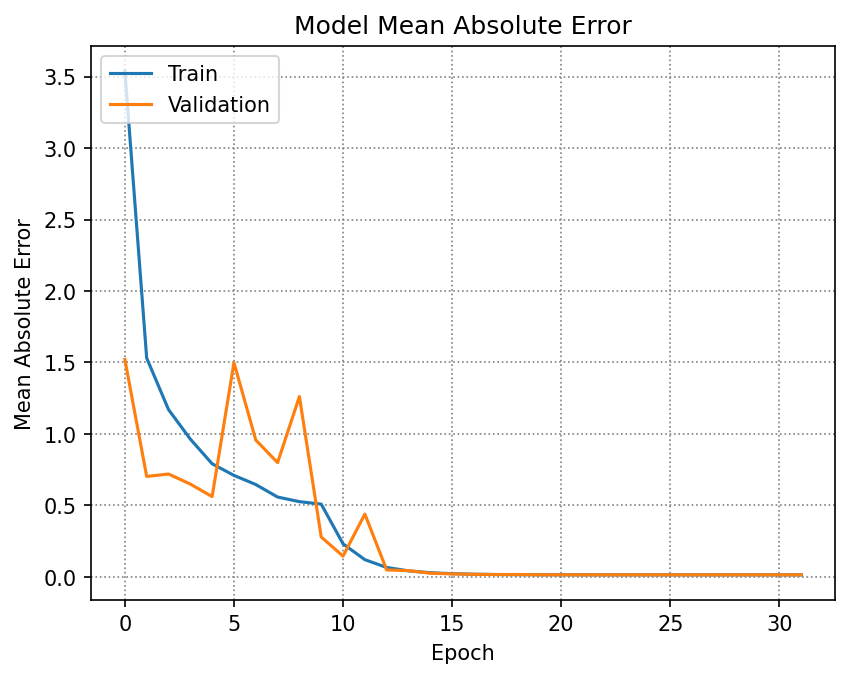

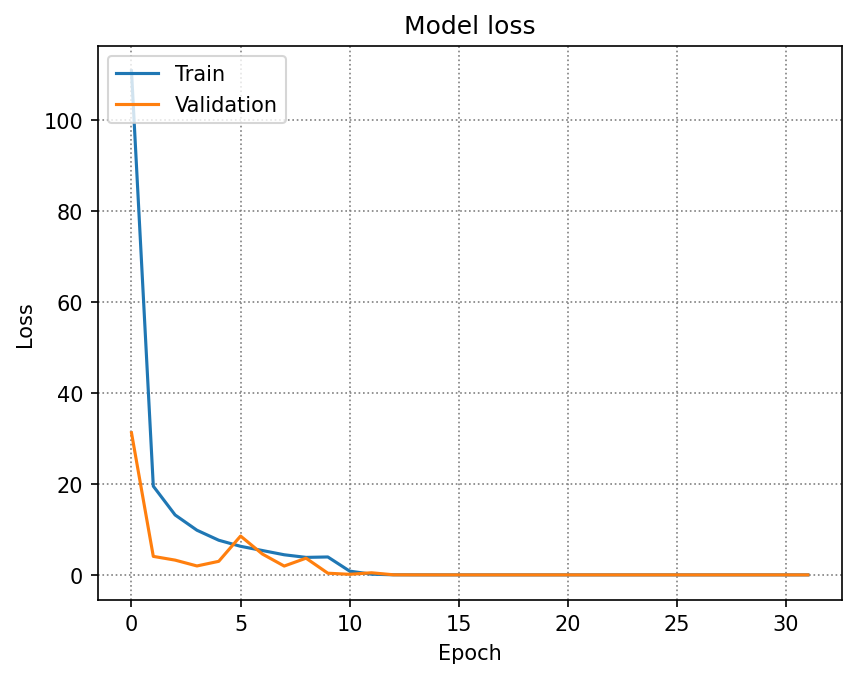

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[294.98   0.24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[508.     0.13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[196.5    0.13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[295.04   0.06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[508.     0.49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[195.97   0.49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[195.59   0.14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[196.02   0.24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[508.     0.97]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[508.01   0.98]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


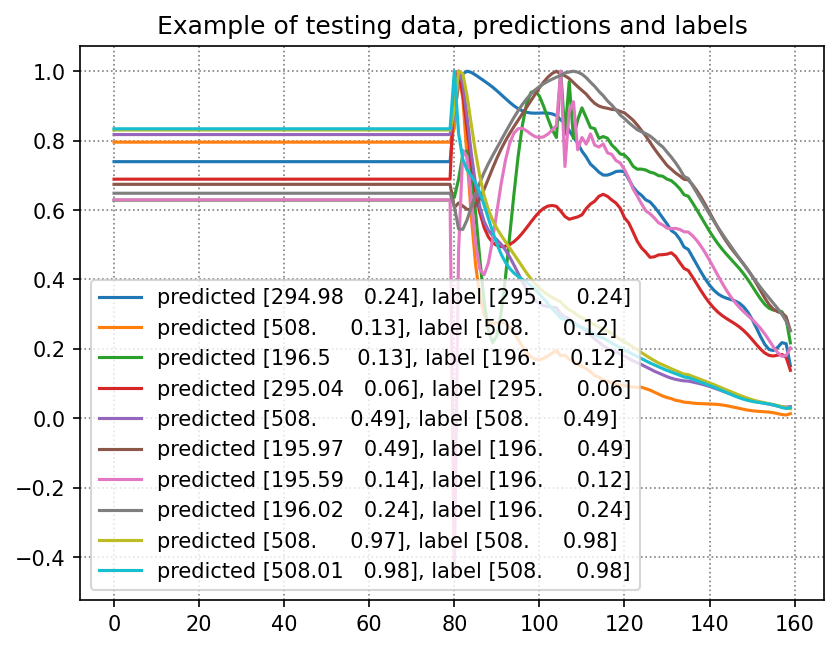

16563/16563 ━━━━━━━━━━━━━━━━━━━━ 13s 781us/step
Predicted:  [294.98   0.24]
Label:  [295.     0.24]
Predicted:  [508.     0.13]
Label:  [508.     0.12]
Predicted:  [196.5    0.13]
Label:  [196.     0.12]
Predicted:  [295.04   0.06]
Label:  [295.     0.06]
Predicted:  [508.     0.49]
Label:  [508.     0.49]


<Figure size 960x720 with 0 Axes>

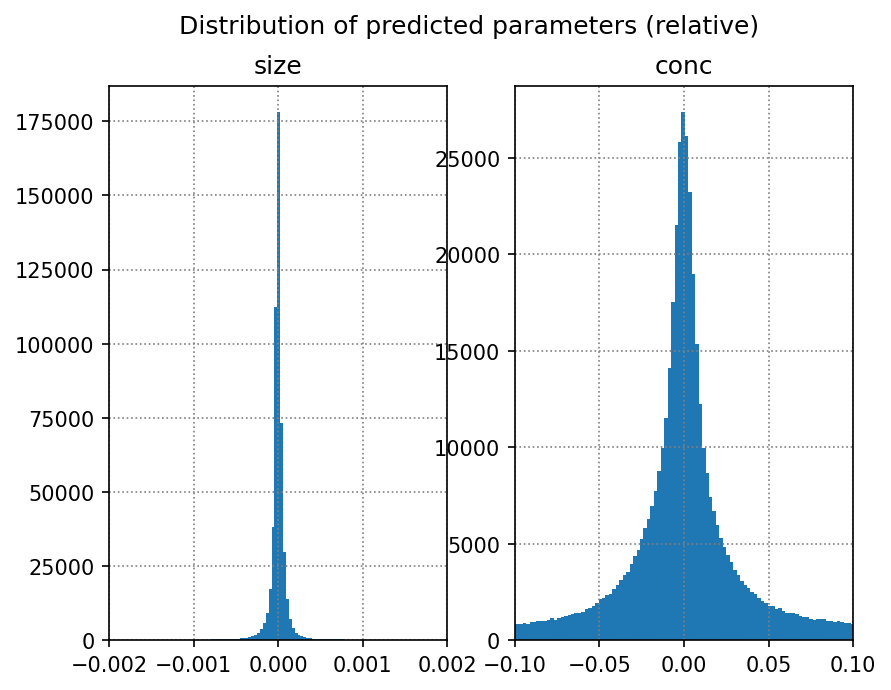

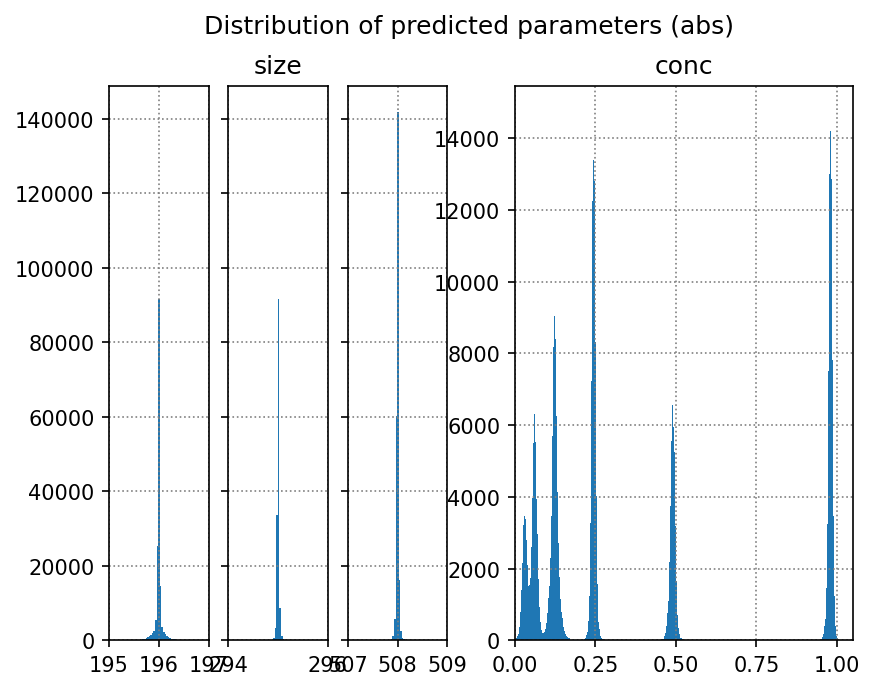

C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_16084\242464662.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


<Figure size 960x720 with 0 Axes>

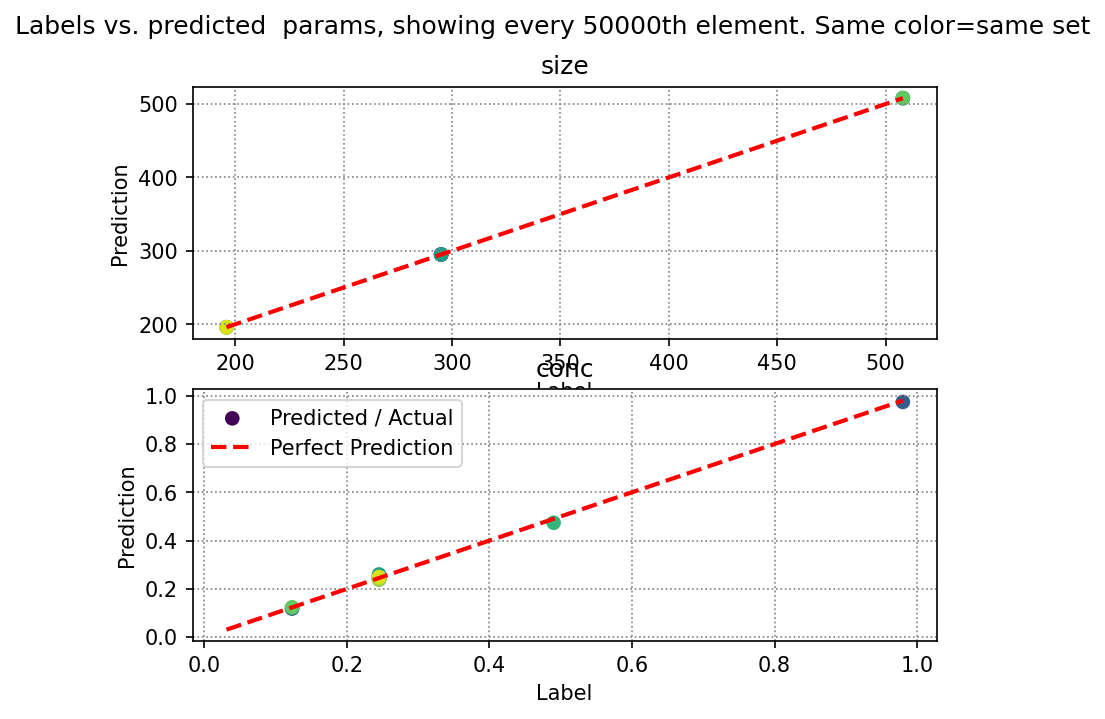

<Figure size 960x720 with 0 Axes>

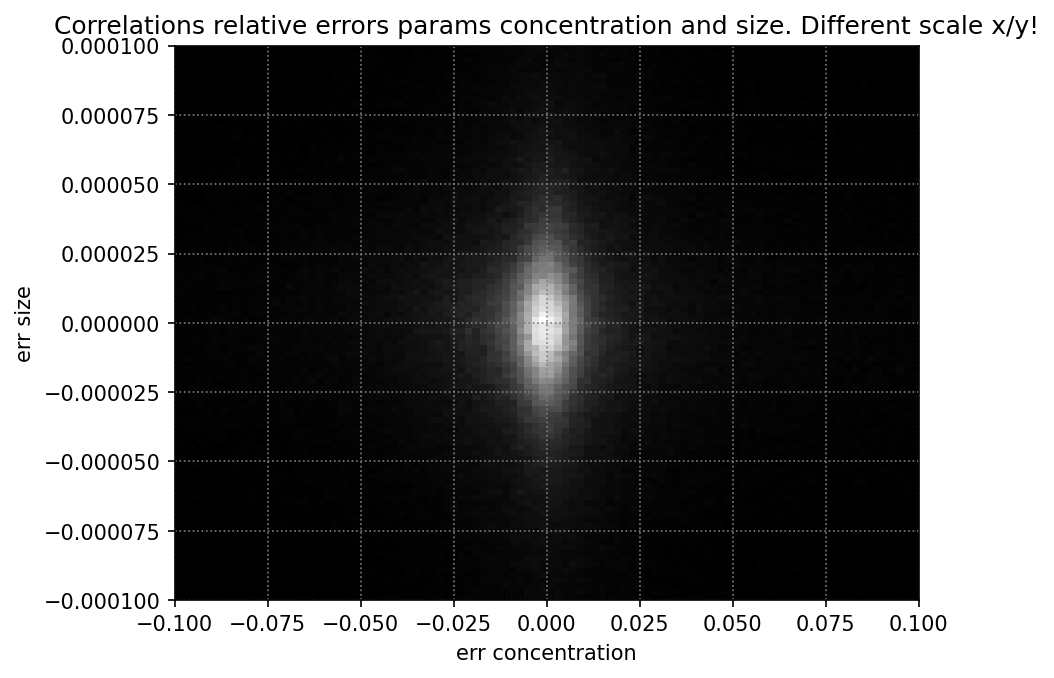

In [26]:
# CHECKS
"""
In this section, we evaluate the fit by plotting several monitored parameters, like mean absolute error.
"""

# Evaluate the model:
loss, mae = model.evaluate(x_test, y_test)
print(f'Test mae: {mae}')

# Summary to visualize the model
# model.summary()

# Plot training & validation Mean Absolute Error values:
plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
np.set_printoptions(suppress=True, precision=2) # numpy number print without scientific format

# Quick visual test:
plt.figure()
for i in range(10):
    print(model.predict(x_test[i].reshape(1, -1))[0])
    prediction = model.predict(x_test[i].reshape(1, -1))[0] # 2D because batch predictions
    plt.plot(x_test[i], label="predicted " + str(prediction) + ", label " + str(y_test[i]))
plt.legend()
plt.title("Example of testing data, predictions and labels")
plt.show()

# Quick test: random point "in-between" (when trained on mixtures as well)
# plt.figure()
# for i in range(3):
#     prediction = model.predict((x_test[i]/2+x_test[i+1]/2).reshape(1, -1))[0] # 2D because batch predictions
#     plt.plot(x_test[i]/2+x_test[i+1]/2, label="predicted " + str(prediction) + ", label " + str(y_test[i]) + " + "+str(y_test[i+1]))
# plt.title("mixture")
# plt.legend()


# Predict on test data
y_pred = model.predict(x_test)


# all parameters pred + label:
for i in range(5):
    print("Predicted: ", y_pred[i])
    print("Label: ", y_test[i])


# HISTOGRAMS RELATIVE
plt.figure()
fig, axs = plt.subplots(1, 2)
axs[0].hist((y_pred[:,0]-y_test[:,0])/y_test[:,0], bins=10000)
axs[0].set_title("size")
axs[1].hist((y_pred[:,1]-y_test[:,1])/y_test[:,1], bins=5000)
axs[0].set_xlim((-0.002, 0.002))
axs[1].set_xlim((-0.1, 0.1))
axs[1].set_title("conc")
plt.suptitle("Distribution of predicted parameters (relative)")
plt.show()

# HISTOGRAMS ABSOLUTE
import matplotlib.gridspec as gridspec
fig = plt.figure()
gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])
ax3 = fig.add_subplot(gs00[2])
ax1.hist(y_pred[:,0], bins=10000)
ax1.set_xlim((195,197))
#ax1.set_title("size")

ax2.hist(y_pred[:,0], bins=10000)
ax2.set_xlim((294,296))
ax2.set_title("size")
ax2.set_yticklabels([])

ax3.hist(y_pred[:,0], bins=10000)
ax3.set_xlim((507,509))
#ax3.set_title("size")
ax3.set_yticklabels([])

#gs01 = gs0[1].subgridspec(3, 3)
ax4 = fig.add_subplot(gs0[1])
ax4.hist(y_pred[:,1], bins=1000)
ax4.set_xlim((0,1.05))
ax4.set_title("conc")

plt.suptitle("Distribution of predicted parameters (abs)")
plt.show()






# EACH PARAMETER SEPARATELY:
plt.figure()
fig, axs = plt.subplots(2, 1)
norm = Normalize(vmin=0, vmax=len(y_pred)-1)
cmap = cm.get_cmap('viridis')
colors = cmap(norm(range(len(y_pred))))
slicing = 50000

param_index = 0  # Index of the parameter to plot
axs[0].scatter(y_test[::slicing, param_index], y_pred[::slicing, param_index], c=colors[::slicing], label='Predicted / Actual')
axs[0].plot([y_test[:, param_index].min(), y_test[:, param_index].max()], 
         [y_test[:, param_index].min(), y_test[:, param_index].max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Prediction')
axs[0].set_title("size")

param_index = 1  # Index of the parameter to plot
axs[1].scatter(y_test[::slicing, param_index], y_pred[::slicing, param_index], c=colors[::slicing], label='Predicted / Actual')
axs[1].plot([y_test[:, param_index].min(), y_test[:, param_index].max()], 
         [y_test[:, param_index].min(), y_test[:, param_index].max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Prediction')
axs[1].set_title("conc")

plt.suptitle(f'Labels vs. predicted  params, showing every {slicing}th element. Same color=same set')
plt.legend()
plt.show()


# KORELACIJE NAPAK:
plt.figure()
errdict={0:"size", 1:"concentration"}
range1 = [[-0.1, 0.1],[-0.0001, 0.0001]]
for i1 in [0,1]:
    for i2 in [0,1]:
        if i1 != i2 and i1 < i2:
            plt.figure()
            plt.title(f"Correlations relative errors params {errdict[i2]} and {errdict[i1]}. Different scale x/y!" )
            plt.hist2d(
                (y_pred[:,i2]-y_test[:,i2])/y_test[:,i2],
                (y_pred[:,i1]-y_test[:,i1])/y_test[:,i1],
                bins=[100, 100], range=range1, cmap='grey')
            plt.xlabel(f"err {errdict[i2]}")
            plt.ylabel(f"err {errdict[i1]}")
            #plt.gca().set_aspect('equal', adjustable='box')
            plt.show()

In [ ]:
#TO DO: don't include one concentration in training data, but include it in testing data. Mixtures?

In [ ]:
# ---------------------GRID SEARCH-------------------------------------------
# """
# A method to find optimal parameters
# """
# def build_model(optimizer='adam'):
#     model = Sequential([
#         Input(shape=(len(x_train[0]),)),
#         Dense(512, activation='relu'),
#         Dense(256, activation='relu'),
#         Dense(128, activation='relu'),
#         Dense(64, activation='relu'),
#         Dense(1, activation="linear")
#     ])
#     model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
#     return model

# model = KerasRegressor(build_fn=build_model, verbose=1)
# param_grid = {'batch_size': [32, 64, 128], 'epochs': [20, 50, 100], 'optimizer': ['adam', 'rmsprop']}
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(x_train, y_train)

# print(f"Best: using {grid_result.best_params_}")
# Best: nan using {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam'}